In [138]:
# Pytorch library for matrix (tensor) operations and matplotlib for visualizing the data.
import torch
import torch.nn.functional as torchf
import matplotlib.pyplot as plot
%matplotlib inline

In [139]:
# A list of the top baby names in lowercase.
words = open("names_short.txt", "r").read().splitlines()
for (index, word) in enumerate(words):
    words[index] = word.lower()
len(words)

2000

In [140]:
words[:10]

['liam',
 'olivia',
 'noah',
 'emma',
 'oliver',
 'amelia',
 'theodore',
 'charlotte',
 'james',
 'mia']

In [141]:
# Lookup tables used to convert our input to a numerical representation and back.
#
# We use a sorted set of all characters as the vocabulary. Then create a mapping from elements in the vocabulary to their index
# and another mapping in reverse.
# NOTE: The special character '.' is added to specify the start and end of a word.

input_vocab = sorted(list(set(".".join(words))))
stoi = { s: i for i, s in enumerate(input_vocab) }
itos = { i: s for s, i in stoi.items() }

In [142]:
# We'll train on bigrams (i.e. looking at the previous character, predict the next), so let's take a look at the counts of all bigrams.
bigram_counts = torch.zeros((len(input_vocab), len(input_vocab)), dtype=torch.int32)

# Create combinations of input letter + next letter and count the occurances.
for word in words:
    chars = ["."] + list(word) + ["."]
    # Loop over two lists, the characters and the characters offset by one (i.e. input -> target).
    for input_letter, output_letter in zip(chars, chars[1:]):
        bigram_counts[stoi[input_letter], stoi[output_letter]] += 1

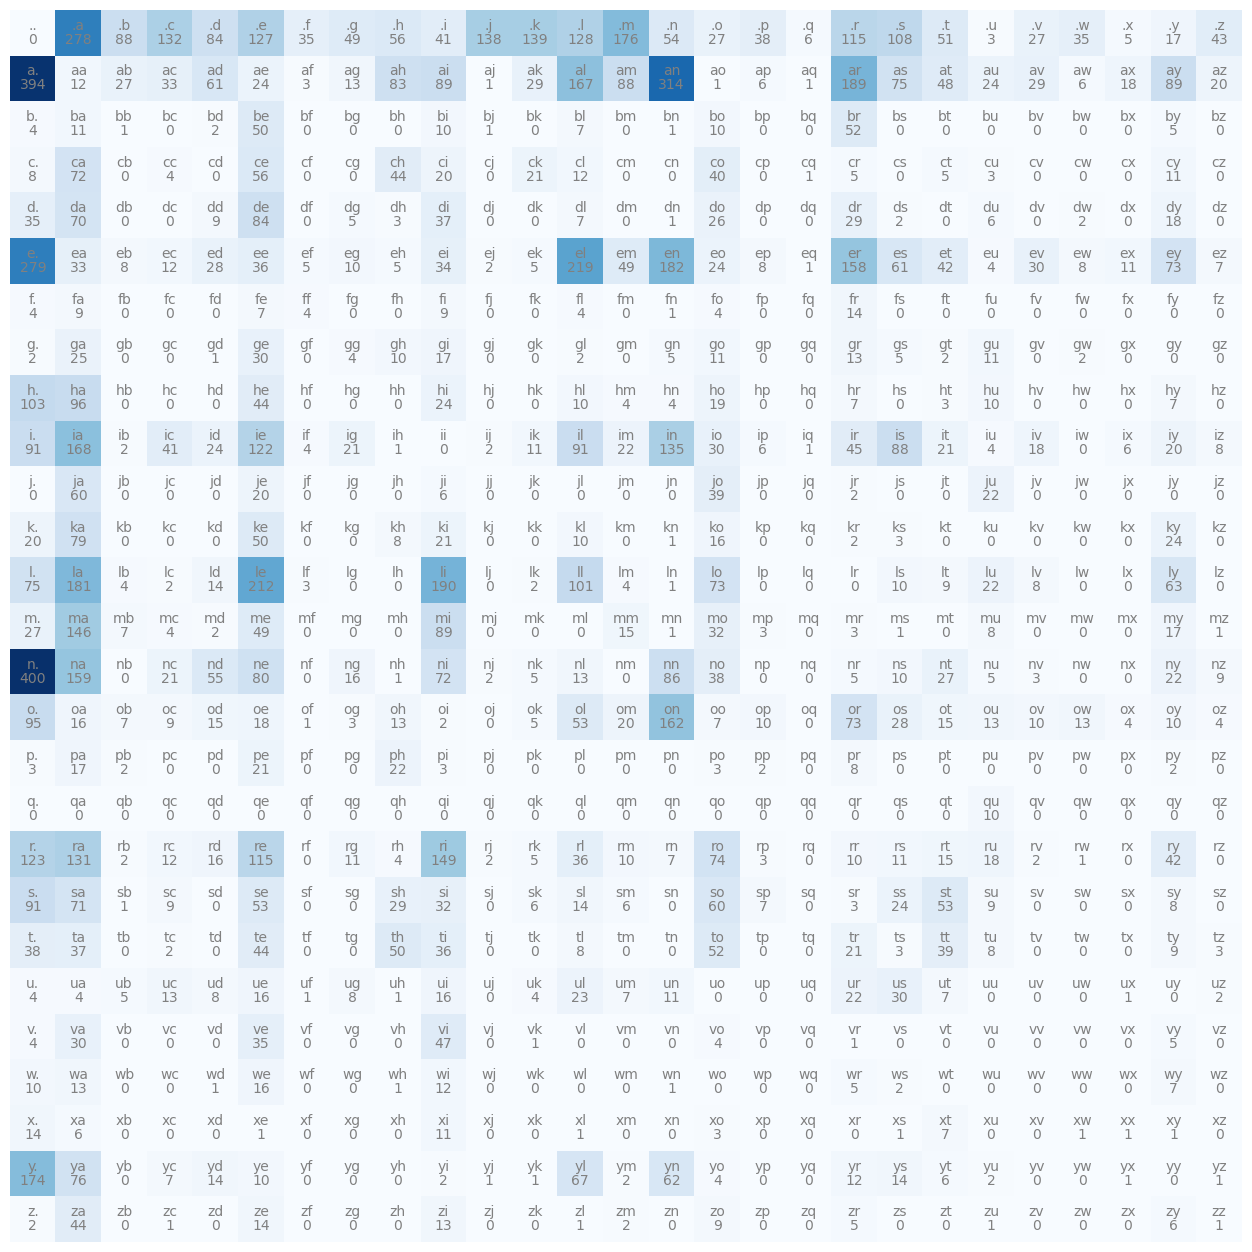

In [143]:
# Draw a table of the bigram counts with a blue heatmap. 
plot.figure(figsize=(16,16))
plot.imshow(bigram_counts, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plot.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plot.text(j, i, bigram_counts[i, j].item(), ha="center", va="top", color='gray')
plot.axis('off');

In [144]:
# Let's normalize the counts into probabilities and use that as a lookup table to predict the next character.
probabilities = bigram_counts / bigram_counts.sum(1, keepdim=True)

for _ in range(10):
    output = ""
    position = 0

    while True:
        output_probabilities = probabilities[position]
        position = torch.multinomial(output_probabilities, num_samples=1, replacement=True).item()

        if position == 0:
            break;

        output += itos[position]

    print(output);


mcera
bergazya
ndstendylolaletr
lula
evemieya
de
chle
adisarin
allovimei
d


In [145]:
# That's not much better than nonsense, so let's try a simple neural network.

# For a neural network, we need to divide our data into two sets for training, a list of inputs and a list of outputs.
input_indices, output_indices = [], []

# Create combinations of input letter + next letter and count the occurances.
for word in words:
    chars = ["."] + list(word) + ["."]
    # Loop over two lists, the characters and the characters offset by one (i.e. input -> target).
    for input_letter, output_letter in zip(chars, chars[1:]):
        input_indices.append(stoi[input_letter])
        output_indices.append(stoi[output_letter])

# Convert the lists to tensors for processing
inputs = torch.tensor(input_indices)
outputs = torch.tensor(output_indices)

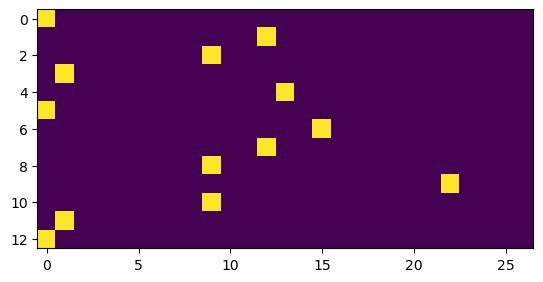

In [146]:
# The inputs will be fed into the neural network with "one-hot" encodings, which just means each input letter is expanded
# to a tensor the length of the vocabulary that is all zeros with the letter index set to one, i.e. the tensor is hot or
# activated on the input letter. As an example, the following plot shows "liam" and "olivia" encoded as one-hots.
encoded = torchf.one_hot(inputs[:13], num_classes=27).float()
plot.imshow(encoded)

In [147]:
# This simple neural network will have 27 "neurons" one for each letter in the vocabulary. The main representation of the
# network will be the weights, a matrix of values that represent the transformation of inputs to outputs. With 27 neurons,
# the weights will be a 27 x 27 matrix.
weights = torch.randn((27, 27), requires_grad=True)

In [148]:
# Training runs.
#
# During each training round a forward pass and backward pass are run, the results of which are used to adjust the values
# of the weights. A forward pass is encoding the inputs as a one-hot tensor, matrix multiplying the encoded inputs with the
# weights, then normalizing the results to get a matrix of probabilities that has the shape of the inputs size by the
# vocabulary size. Then the loss, or an approximation of how far off the model is from the training data is calculated and
# used to adjust the weights. This example uses a log mean function with a weight decay.
for run in range(1000):
    # Forward pass.
    encodings = torchf.one_hot(inputs, num_classes=27).float()
    log_counts = (encodings @ weights).exp()
    probabilities = log_counts / log_counts.sum(1, keepdims=True)
    loss = -probabilities[torch.arange(inputs.nelement()), outputs].log().mean() + 0.01*(weights**2).mean()

    # Backward pass.
    weights.grad = None
    loss.backward()

    # Update the weights with the propagated loss.
    weights.data += -50 * weights.grad

In [149]:
# After training the model, it can be sampled in a way similar to a forward pass to generate new words.
#
# In order to sample from the trained weights, a starting postion is encoded as a one-hot tensor and used
# to calculate a matrix of probabilities, similar to the forward pass above. We can then use the matrix of
for _ in range(10):
    output = ""
    position = 0

    while True:
        encodings = torchf.one_hot(torch.tensor([position]), num_classes=27).float()
        log_counts = (encodings @ weights).exp()
        probabilities = log_counts / log_counts.sum(1, keepdims=True)

        position = torch.multinomial(probabilities, num_samples=1, replacement=True).item()
        if position == 0:
            break

        output += itos[position]

    print(output)

spra
n
ble
en
mm
ka
gselellaxus
l
brondellleoderelisso
ay


In [ ]:
# All those calculations and it wasn't any better than the counting method :(
# Let's make it more complicated!!